# tinyDA UM-Bridge Integration

This notebook demonstrates integration of [UM-Bridge](https://github.com/UM-Bridge/umbridge) with [tinyDA](https://github.com/mikkelbue/tinyDA). 

### Problem setup
In this example, we solve the inverse Euler-Bernoulli [beam problem](https://github.com/UM-Bridge/benchmarks/tree/achlys/models/muq-beam) through [MUQ](https://mituq.bitbucket.io/source/_site/index.html). The "true" beam stiffness is drawn from a log-Gaussian Process. We compute the beam deflection and add some noise to make up the data. The posterior distribution of beam stiffnesses given the (noisy) deflection data is then recovered using MCMC.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

import tinyDA as tda
import umbridge

In [2]:
np.random.seed(111)

### Initialising UM-Bridge
Before running the following cell, the beam model Docker image must be started from a system terminal using

`docker run -it -p 4242:4242 linusseelinger/model-muq-beam:latest`

In [3]:
# connect to the UM-Bridge model. Change URL if needed (e.g. to 'http://localhost:4242' for a model on the same machine).
umbridge_model = umbridge.HTTPModel('http://model:4242', "forward")

# the beam stiffness is a log-Gaussian process, 
# so we have to transform the GP input before sending it to the UM-Bridge model
E = lambda x: 1e5*np.exp(x)

# wrap the UM-Bridge model in the tinyDA UM-Bridge interface.
my_model = tda.UmBridgeModel(umbridge_model, pre=E)

### Problem setup

In [4]:
# get the number of inputs and outputs.
nx = umbridge_model.get_input_sizes()[0] #the input is the stiffness for each finite element along the beam.
ny = umbridge_model.get_output_sizes()[0] #the outout is the deflection for each finite element.

# set up a grid for the input.
x = np.linspace(0, 1, nx)

# set up the GP prior.
l = 0.5 # length scale.0
C = np.exp(-0.5*distance_matrix(x[:,np.newaxis], x[:, np.newaxis])**2/l**2)# + 1e-6*np.eye(nx) # kernel matrix
my_prior = multivariate_normal(np.zeros(nx), C, allow_singular=True) # zero mean GP.

In [5]:
# set the noise in the data.
sigma_noise = 1e-3

# generate a draw from the prior and pass it through the model
log_E_true = my_prior.rvs()
d_true = my_model(log_E_true)

# add some noise to the model output
d = d_true + np.random.normal(loc=0, scale=sigma_noise, size=ny)

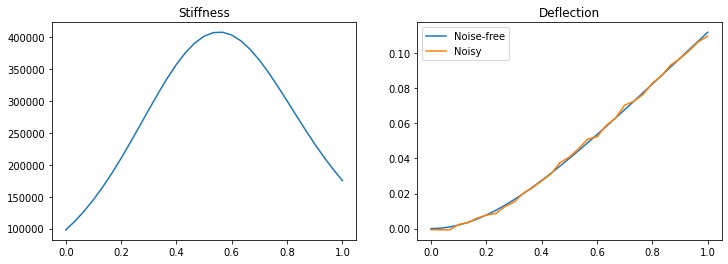

In [6]:
# plot the model input and output.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# plot the stiffness.
ax[0].set_title('Stiffness')
ax[0].plot(x, E(log_E_true))

# plot the deflection
ax[1].set_title('Deflection')
ax[1].plot(x, d_true, label='Noise-free')
ax[1].plot(x, d, label='Noisy')
ax[1].legend()
plt.show()

In [7]:
# set the likelihood
sigma_like = 1e-2 # use slightly more noise for the likelihood.
cov_likelihood = sigma_like**2*np.eye(nx)
my_loglike = tda.GaussianLogLike(d, cov_likelihood)

In [8]:
# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [9]:
# preconditioned Crank-Nicolson
pcn_scaling = 0.1
pcn_adaptive = True
my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

### Sample

In [10]:
# For testing purposes, iteration number is small for the given problem; Choose a larger number for real applications.
my_chains = tda.sample(my_posterior, my_proposal, iterations=10000, n_chains=2, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.23:   3%|▎          | 3777/120000 [00:08<04:29, 431.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Running chain, α = 0.20:  11%|█▏        | 13738/120000 [00:33<04:44, 373.45it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Running chain, α = 0.16:  88%|███████▉ | 105206/120000 [04:49<00:52, 279.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Sampling chain 2/2


Running chain, α = 1.00:   0%|                       | 0/120000 [00:00<?, ?it/s]/home/mikkel/venv/tinyda/lib/python3.8/site-packages/tinyDA/proposal.py:343: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.likelihood - previous_link.likelihood)
Running chain, α = 0.17: 100%|█████████| 120000/120000 [05:29<00:00, 364.35it/s]


### Get some diagnostics

In [11]:
import arviz as az

In [12]:
# convert the tinyDA chains to an ArViz InferenceData object.
idata = tda.to_inference_data(my_chains, burnin=1000)

/home/mikkel/venv/tinyda/lib/python3.8/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [13]:
# display posterior summary statistics.
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.301,0.871,-1.292,1.867,0.046,0.032,371.0,683.0,1.01
theta_1,0.326,0.866,-1.252,1.879,0.045,0.032,370.0,681.0,1.01
theta_2,0.351,0.860,-1.213,1.899,0.045,0.032,368.0,693.0,1.01
theta_3,0.377,0.852,-1.156,1.918,0.045,0.032,366.0,711.0,1.00
theta_4,0.402,0.844,-1.119,1.914,0.044,0.031,364.0,736.0,1.00
theta_5,0.427,0.833,-1.061,1.935,0.044,0.031,362.0,757.0,1.00
theta_6,0.451,0.821,-1.015,1.938,0.043,0.031,361.0,767.0,1.00
theta_7,0.476,0.806,-0.967,1.930,0.043,0.030,359.0,776.0,1.00
theta_8,0.500,0.789,-0.875,1.955,0.042,0.030,358.0,768.0,1.00
theta_9,0.523,0.769,-0.818,1.941,0.041,0.029,357.0,773.0,1.00


/home/mikkel/venv/tinyda/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  warnings.warn(


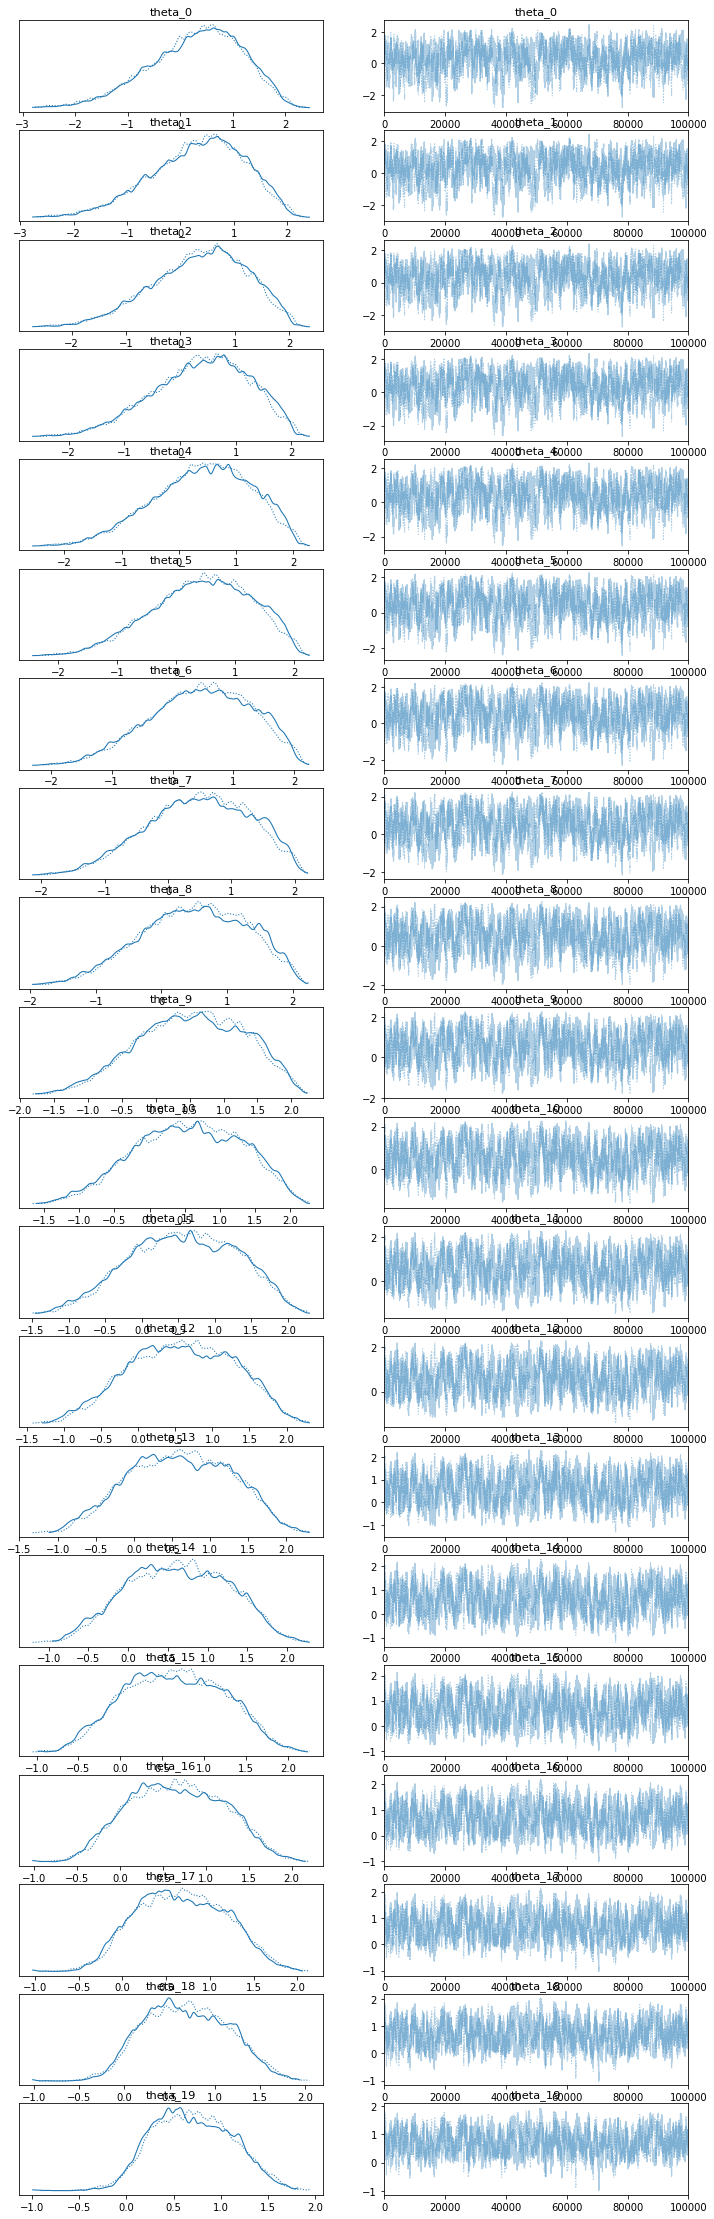

In [14]:
# plot posterior kernel densities and traces.
az.plot_trace(idata)
plt.show()

In [15]:
# extract the parameters from the chains.
parameters = [link.parameters for link in my_chains['chain_0'][2001:] + my_chains['chain_1'][2001:]]

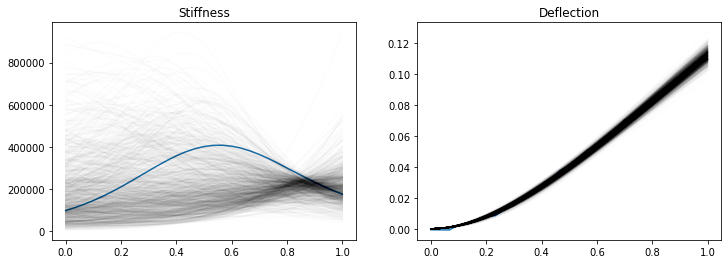

In [16]:
# plot some posterior draws of the model input and output.
n_samples = 1000
ids = np.random.randint(0, len(parameters), n_samples)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# plot the stiffness.
ax[0].set_title('Stiffness')
ax[0].plot(x, E(log_E_true))
for i in ids:
    ax[0].plot(x, E(parameters[i]), c='k', alpha=0.01)

# plot the deflection
ax[1].set_title('Deflection')
ax[1].plot(x, d)
for i in ids:
    ax[1].plot(x, my_model(parameters[i]), c='k', alpha=0.01)
plt.show()